# 1. Introduction

## 1.1 Imports
Import libraries here.

In [1]:
import pandas as pd
import numpy as np

In [2]:
from kuberspatiotemporal import CompoundModel, Feature, SpatialModel, KuberModel
from kuberspatiotemporal.tools import make_ellipses

kuberspatiotemporal.spatial


In [3]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer

# 2. Load Data

In [4]:
data = pd.read_json('data/spatial_data_lisboa.json')

In [5]:
data.head(2)

,id,user_id,os,dataversion,appversion,encrypted,timestamp,latitude,longitude,organization_uid,score,accuracy
0,1257521,lisboa,android,21,21,False,2019-06-07 12:12:55+00:00,38.710482,-9.139440,3,-1.0,-1
1,1257522,lisboa,android,21,21,False,2019-06-07 12:13:07+00:00,38.710491,-9.139443,3,-1.0,-1


In [6]:
spatial_data = data[['latitude', 'longitude', ]] 

In [7]:
grouped_locations = data.groupby(['latitude', 'longitude']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)

In [8]:
# Filter office and home locations
data2 = data[['latitude', 'longitude']]
data2 = data2[((((data2['latitude']>38.710104) & (data2['latitude']<38.710648)) | ((data2['latitude']>38.725828) & (data2['latitude']<38.726512)) 
              &
             (((data2['longitude']>-9.139794) & (data2['longitude']<-9.1389)) | ((data2['longitude']>-9.133944) & (data2['longitude']<-9.133169)))))]

In [9]:
data2

,latitude,longitude
0,38.710482,-9.139440
1,38.710491,-9.139443
2,38.710490,-9.139442
3,38.710490,-9.139442
4,38.710280,-9.144349
...,...,...
8394,38.710482,-9.139465
8395,38.710482,-9.139465
8405,38.710483,-9.139454
8406,38.710483,-9.139454


In [10]:
data2 = data[['latitude', 'longitude']]
data2 = data2[(
    (((data2['latitude']>38.710104) & (data2['latitude']<38.710648)) & ((data2['longitude']>-9.139794) & (data2['longitude']<-9.1389)))
 | (((data2['latitude']>38.725828) & (data2['latitude']<38.726512)) & ((data2['longitude']>-9.133944) & (data2['longitude']<-9.133169))))]

data2



,latitude,longitude
0,38.710482,-9.139440
1,38.710491,-9.139443
2,38.710490,-9.139442
3,38.710490,-9.139442
10,38.726250,-9.133597
...,...,...
8394,38.710482,-9.139465
8395,38.710482,-9.139465
8405,38.710483,-9.139454
8406,38.710483,-9.139454


In [11]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, CircleMarker

m = Map(center=(np.mean(data.latitude), np.mean(data.longitude)), zoom=10)

for lat, lon, count in zip(grouped_locations.latitude.values, grouped_locations.longitude.values, grouped_locations.Count.values):
    circle_marker = CircleMarker()
    circle_marker.location = (lat, lon)
    circle_marker.radius = int((count-1)*(25-3)/(np.max(grouped_locations.Count.values)-np.min(grouped_locations.Count.values))+3)
    circle_marker.color = "blue"
    circle_marker.fill_color = "blue"

    m.add_layer(circle_marker)

m

KeyboardInterrupt: 

In [ ]:
for lat, lon in zip(data2.latitude.values, data2.longitude.values):
    circle_marker = CircleMarker()
    circle_marker.location = (lat, lon)
    circle_marker.radius = 3
    circle_marker.color = "red"
    circle_marker.fill_color = "red"

    m.add_layer(circle_marker)

In [11]:
limits = np.array([[data.latitude.min(), data.longitude.min()],[data.latitude.max(), data.longitude.max()]])
limits

array([[38.6900006, -9.4216553],
       [38.7855706, -9.0955802]])

# 3. Learn Spatial Model - 2D

In [12]:
model = SpatialModel(n_dim=2, min_eigval=1e-10, nonparametric=True, n_iterations=200, limits=limits,
                    scaling_parameter=1.5, loa=True)

In [13]:
idx = np.argsort(model._weights)

In [14]:
model.fit(data[['latitude', 'longitude']].values)

SpatialModel(n_dim=2, n_components=100, nonparametric=True, scaling_parameter=1.5, decay=0.75, online_learning=False, n_iterations=200, score_threshold=None, random_reset=False, loa=True, _sufficient_statistics=`list of length 3, elements of shapes [(100,), (100, 2), (100, 2, 2)]`, _BaseModel__priors=Array (100,), _weights=Array (100,), limits=array([[38.6900006, -9.4216553],
       [38.7855706, -9.0955802]]), min_eigval=1e-10, box=None, _SpatialModel__means=Array (100, 2), _SpatialModel__covs=Array (100, 2, 2))

In [15]:
idx = np.argsort(model._weights)
idx

array([95, 97, 92, 91, 90, 87, 96, 85, 80, 76, 82, 88, 69, 79, 94, 73, 71,
       68, 62, 81, 98, 86, 66, 61, 58, 54, 53, 52, 72, 55, 93, 77, 51, 60,
       89, 75, 83, 47, 42, 78, 49, 84, 38, 46, 36, 45, 39, 74, 34, 63, 37,
       32, 40, 67, 31, 70, 28, 26, 27, 65, 35, 23, 64, 24, 20, 19, 44, 14,
       59, 21, 43, 56, 25, 17, 29, 11, 13, 18,  9, 30, 57,  1, 10, 22, 48,
        7, 33, 99, 50,  6, 41,  8,  4, 15,  2,  5, 12,  3, 16,  0])

In [16]:
# weights 
# model._weights
# covs
# model._SpatialModel__covs
# means
# model._SpatialModel__means

In [17]:
model._weights

array([4.88754164e-01, 6.67537262e-04, 9.61315002e-03, 2.09408155e-02,
       3.10029055e-03, 1.06562441e-02, 1.48015801e-03, 8.32425847e-04,
       2.46325329e-03, 4.47577985e-04, 6.98040380e-04, 1.88123825e-04,
       1.91617875e-02, 2.02102180e-04, 2.58677692e-05, 8.09517827e-03,
       4.23029234e-01, 1.18926817e-04, 3.56777474e-04, 1.35062102e-06,
       6.99104744e-07, 1.18744096e-04, 7.08601017e-04, 6.50845459e-08,
       1.51898064e-07, 1.18922013e-04, 9.60375625e-10, 1.14099939e-09,
       3.58568464e-10, 1.73047590e-04, 4.89326158e-04, 1.82555302e-10,
       6.12632199e-11, 1.18616516e-03, 4.78386300e-12, 4.26477443e-09,
       7.11755400e-13, 2.97585320e-11, 1.48279009e-13, 2.67956066e-12,
       7.05125379e-11, 2.01635130e-03, 4.17949491e-15, 1.18790966e-04,
       5.18500243e-06, 8.21955543e-13, 1.66532444e-13, 2.37959817e-15,
       8.32350698e-04, 2.76998099e-14, 1.35422392e-03, 2.72853689e-16,
       7.20849599e-19, 2.81427226e-19, 1.04749714e-19, 5.73508930e-17,
      

In [18]:
model._SpatialModel__means

array([[38.72628626, -9.13386418],
       [38.70138244, -9.38970682],
       [38.72104613, -9.13339224],
       [38.73458376, -9.14722281],
       [38.74586074, -9.19975163],
       [38.7262859 , -9.13386498],
       [38.73549241, -9.15855368],
       [38.70214083, -9.42115542],
       [38.73583366, -9.13900874],
       [38.71632297, -9.19513799],
       [38.71231405, -9.18698031],
       [38.72628621, -9.13386436],
       [38.71707226, -9.14327507],
       [38.72628625, -9.13386423],
       [38.72628614, -9.13386454],
       [38.70816425, -9.14477146],
       [38.71050226, -9.13942782],
       [38.6958514 , -9.1956767 ],
       [38.7288324 , -9.1136103 ],
       [38.72628628, -9.13386391],
       [38.72628628, -9.13386392],
       [38.7401078 , -9.1231434 ],
       [38.76697275, -9.13166255],
       [38.70213345, -9.42114263],
       [38.72628613, -9.13386456],
       [38.7174598 , -9.4174834 ],
       [38.7174598 , -9.4174834 ],
       [38.72628628, -9.13386394],
       [38.72628628,

In [19]:
model.box=0.005

In [20]:
#home
model.score(np.array([[38.7263483,-9.135931]]))

0.31648121236611604

In [21]:
#office
model.score(np.array([[38.7104174,-9.1417113]]))

0.24441630287814797

In [22]:
from sklearn.mixture import GaussianMixture
bhvr = GaussianMixture()
bhvr.means_ = model._SpatialModel__means
bhvr.covariances_ = model._SpatialModel__covs
bhvr.weights_ = model._weights

bhvr.precisions_cholesky_ = np.linalg.cholesky(
    np.linalg.inv(model._SpatialModel__covs)).transpose((0, 2, 1))

bhvr.score_samples(np.array([[38.7263483,-9.135931]]))

array([9.52086021])

In [23]:
np.prod(1-bhvr.predict_proba(np.array([[38.7263483,-9.135931]])))

0.025810430728235006

In [24]:
limits2 = np.array([[data2.latitude.min(), data2.longitude.min()],[data2.latitude.max(), data2.longitude.max()]])
limits2

array([[38.7102492, -9.139562 ],
       [38.7265033, -9.1334308]])

In [25]:
model2 = SpatialModel(n_dim=2, min_eigval=1e-5, nonparametric=False, n_iterations=200, limits=limits2, n_components=2,
                    scaling_parameter=0.25, loa=True)
model2.fit(data2.values)

/Users/adrianai/Desktop/aiml/kuberspatiotemporal/src/kuberspatiotemporal/base.py:443: RuntimeWarning: invalid value encountered in true_divide
  self._weights /= np.sum(self._weights)


AttributeError: 'Logger' object has no attribute 'Error'

In [ ]:
model2.box=0.005

In [ ]:
#home
model2.score(np.array([[38.7263483,-9.135931]]))

In [ ]:
#office
model2.score(np.array([[38.7104174,-9.1417113]]))

In [ ]:
f, ((ax1, ax2)) = plt.subplots(1,2, figsize=(18, 10))
ax1.scatter(data2.latitude, data2.longitude, marker='o',
            s=25, edgecolor='k')
ax1.set_title('data')

make_ellipses(model2, ax2)
ax2.scatter(data2.latitude, data2.longitude,
            s=25, edgecolor='k')
ax2.set_title('ellipses')

## 3.1 Prediction grid

In [24]:
from typing import Union
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.stats import mvn
from scipy.stats._multivariate import _squeeze_output

def is_broadcastable(a: Union[float, np.ndarray], b: Union[float, np.ndarray]) -> bool:
    r"""Checks whether two objects can be
    `broadcast to each other <https://stackoverflow.com/a/47244284>`_
    """
    return all((m == n) or (m == 1) or (n == 1) for m, n in zip(a.shape[::-1], b.shape[::-1]))

def boxed_cumulative(gmm: Union[GaussianMixture, BayesianGaussianMixture],
                     centers: np.ndarray, width: Union[float, np.ndarray],
                     maxpts: float = None, abseps=1e-5, releps=1e-5) -> Union[float, np.ndarray]:
    r"""Compute the *boxed* cumulative density of a Gaussian Mixture Model function given the centers and
    widths of one or more intervals.

    Parameters
    ----------
    centers : ndarray
        The centers of the boxes to compute the cumulative function for. Row matrix
        of points. Number of columns must match the dimension of the mean parameter.
    width : float or ndarray
        The width of the box. Must be able to be broadcast to the first parameter.
    mean : ndarray
        See :data:`scipy.stats.multivariate_normal`
    cov : ndarray
        See :data:`scipy.stats.multivariate_normal`
    maxpts : float
        See :data:`scipy.stats.multivariate_normal`
    abseps : float
        See :data:`scipy.stats.multivariate_normal`
    releps : float
        See :data:`scipy.stats.multivariate_normal`
    """
    # XXX SU->SU: Docstring incomplete / requires checking
    return np.sum(
        [
            weight *
            boxed_cdf(centers, width, mean, sigma, maxpts, abseps, releps)
            for sigma, mean, weight in zip(gmm.covariances_, gmm.means_, gmm.weights_)
        ]
    )


def boxed_cdf(
        centers: np.ndarray, width: Union[float, np.array],
        mean: np.ndarray, cov: np.ndarray,
        maxpts: float = None, abseps=1e-5, releps=1e-5) -> Union[float, np.ndarray]:
    """
    Compute the *boxed* cumulative density function given the centers and
    widths of one or more intervals.

    Parameters
    ----------
    centers : ndarray
        The centers of the boxes to compute the cumulative function for. Row matrix
        of points. Number of columns must match the dimension of the mean parameter.
    width : float or ndarray
        The width of the box. Must be able to be broadcast to the first parameter.
    mean : ndarray
        See :data:`scipy.stats.multivariate_normal`
    cov : ndarray
        See :data:`scipy.stats.multivariate_normal`
    maxpts : float
        See :data:`scipy.stats.multivariate_normal`
    abseps : float
        See :data:`scipy.stats.multivariate_normal`
    releps : float
        See :data:`scipy.stats.multivariate_normal`

    Returns
    -------
    cdf : ndarray or scalar
        Cumulative distribution function evaluated at `x`


    Notes
    -----
    The code is inspired by scipy.stats._multivariate.

    """
    # XXX SU->SU: improve doc string. Missing several parameters

    dim = mean.size

    # Increase dimensionality to 2D if necessary
    centers = np.atleast_2d(centers)
    width = np.atleast_2d(width)

    # check if dimensions are compatible
    assert centers.shape[1] == dim
    assert is_broadcastable(centers, width)

    # We construct a matrix with the intervals defined in the rows
    # the first half of the components are the lower bound,
    # the second half the upper bound.

    lower_upper = np.hstack((centers-width/2., centers+width/2.))

    if not maxpts:
        maxpts = 1000000 * dim

    # mvnun expects 1-d arguments, so process points sequentially
    # We apply the computation along the last axis, so that we
    # process the rows in parallel.

    out = np.apply_along_axis(
        lambda stacked: mvn.mvnun(  # Computes the boxed CDF (fortran wrapper)
            stacked[0:dim],         # First columns represent the lower bound
            stacked[dim:],          # Last columns represent the upper bound
            mean, cov,              # The parameters of the normal distribution
            maxpts, abseps, releps  # Parameters of the algorithm
        )[0], -1, lower_upper
    )
    if np.isnan(out):
        out = np.array([0])

    return _squeeze_output(out)

In [25]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
from ipyleaflet import (
    Rectangle
)
def pcolorOnMap(xx: np.ndarray,
                yy: np.ndarray,
                zz: np.ndarray,
                samples: np.ndarray = None):
    r"""
    Helper plot function for displaying a grid of rectangles on a map.

    Parameters
    ----------
    xx: shape (m, n)
        Array created by :func:`numpy.meshgrid`

    yy: shape (m, n)
        Array created by :func:`numpy.meshgrid`

    zz: shape (m, n)
        Function values of a function :math:`f(xx,yy)`.
        Values of the range 0 to 1.

    samples: shape(2,k)
        Samples (:math:`k`) to be displayed on the map.

    Notes
    -----
    Only implemented if  `ipyleaflet <https://github.com/jupyter-widgets/ipyleaflet>`_ is installed.

    """
    width = (0.5*(xx[0, 1]-xx[0, 0]), 0.5*(yy[1, 0]-yy[0, 0]))
    center = (0.5*(xx[0, -1]+xx[0, 0]), 0.5*(yy[-1, 0]+yy[0, 0]))

    boxes = np.array([xx.flatten(), yy.flatten()]).T

    cmap = plt.cm.get_cmap("viridis")
    world = Map(center=center, zoom=13)

    if samples is not None:
        for loc in samples:
            circle_marker = CircleMarker()
            circle_marker.location = loc.tolist()
            circle_marker.radius = 2
            circle_marker.color = "red"
            circle_marker.fill_color = "red"
            world.add_layer(circle_marker)

    for box, value in zip(boxes, zz.flatten()):
        message = HTML()
        message.value = f"{value*100:.1f}%"
        color = cmap(value/np.max(zz))
        color_hex = to_hex(color, keep_alpha=False)
        rectangle = Rectangle(bounds=((box[0] - width[0], box[1] - width[1]),
                                      (box[0] + width[0], box[1] + width[1])),
                              weight=0, fill_color=color_hex, stroke=False, fill_opacity=0.5)
        world.add_layer(rectangle)
        rectangle.popup = message

    return world

In [26]:
# Draw random value samples from the mixture distribution
model.rvs(1000)

array([[38.72747758, -9.13362626],
       [38.70889852, -9.13830447],
       [38.72371535, -9.19176275],
       ...,
       [38.72564449, -9.13392939],
       [38.72580939, -9.13334127],
       [38.70920661, -9.13991042]])

In [27]:
from ipywidgets import interact, interactive, fixed, interact_manual, HTML

steps=20
# Acquire some sample for getting the boundaries
samples = model.rvs(1000)

# pick min and max values but widen interval by 25%
max_ = np.max(samples, axis=0)
min_ = np.min(samples, axis=0)
width = (max_-min_)

max_ += width * 0.25
min_ -= width * 0.25
width = (max_-min_)

# Compute the probability for each *combination* of x/y values

# we compare sklearn.mixtures.GaussianMixture.score_samples (log if the PDF)
# with our B-CDF approach

xx, yy = np.meshgrid(
    np.linspace(min_[0], max_[0], steps),
    np.linspace(min_[1], max_[1], steps),
)
scores = np.zeros(xx.shape)
probabilities = np.zeros(xx.shape)
probabilities_ = np.zeros(xx.shape)


for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        center = [[xx[i, j], yy[i, j]]]
        probabilities[i, j] =  np.sum(
        [
            weight *
            boxed_cdf(center, width/steps, mean, sigma, maxpts=None, abseps=1e-5, releps=1e-5)
            for sigma, mean, weight in zip(model._SpatialModel__covs, model._SpatialModel__means, model._weights)
        ]
    )


display(pcolorOnMap(xx,yy,probabilities, model._SpatialModel__means))


Map(center=[38.73062475208813, -9.266634266442829], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [28]:
from kuberspatiotemporal.tools import make_ellipses

Text(0.5, 1.0, 'ellipses')

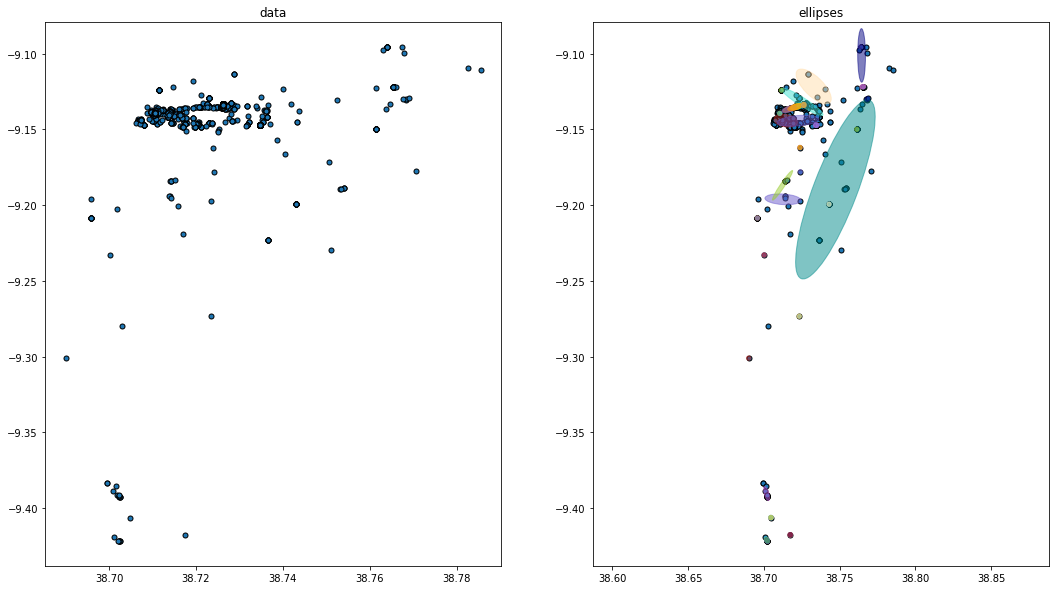

In [29]:
f, ((ax1, ax2)) = plt.subplots(1,2, figsize=(18, 10))
ax1.scatter(data.latitude, data.longitude, marker='o',
            s=25, edgecolor='k')
ax1.set_title('data')

make_ellipses(model, ax2)
ax2.scatter(data.latitude, data.longitude,
            s=25, edgecolor='k')
ax2.set_title('ellipses')

In [30]:
model

SpatialModel(n_dim=2, n_components=100, nonparametric=True, scaling_parameter=1.5, decay=0.75, online_learning=False, n_iterations=200, score_threshold=None, random_reset=False, loa=True, _sufficient_statistics=`list of length 3, elements of shapes [(100,), (100, 2), (100, 2, 2)]`, _BaseModel__priors=Array (100,), _weights=Array (100,), limits=array([[38.6900006, -9.4216553],
       [38.7855706, -9.0955802]]), min_eigval=1e-10, box=0.005, _SpatialModel__means=Array (100, 2), _SpatialModel__covs=Array (100, 2, 2))

# 4. Learn Spatiotemporal Model 

In [ ]:
data.timestamp

In [ ]:
# will be added to the spatial model and interpreted as continuous
data['time'] = [ts.hour + ts.minute/60 + ts.second/3600 for ts in data.timestamp]
# weekday will be part of another model
data['weekday'] = [ts.dayofweek for ts in data.timestamp]

In [ ]:
limits_ = [np.min(data[['latitude', 'longitude', 'time']].values, axis=0),np.max(data[['latitude', 'longitude', 'time']].values, axis=0)]

In [ ]:
kst = CompoundModel(
    n_dim=4,
    n_iterations=200,
    scaling_parameter=1.1,
    nonparametric=True,
    online_learning=False,
    score_threshold=0.85,  
    features=[
        Feature(SpatialModel(n_dim=3, min_eigval=1e-9, limits=limits_), [0, 1, 2]),
        Feature(KuberModel(n_symbols=7), [3])
    ],
)

In [ ]:
pipeline = make_pipeline(
    make_column_transformer(
        (FunctionTransformer(lambda x: np.array(x).reshape(-1, 1)), "latitude"),
        (FunctionTransformer(lambda x: np.array(x).reshape(-1, 1)), "longitude"),
        (FunctionTransformer(lambda x: np.array(x).reshape(-1, 1)), "time"),
        (FunctionTransformer(lambda x: np.array(x).reshape(-1, 1)), "weekday"),
    ),
    kst,
)

In [ ]:
pipeline.fit(data[['latitude', 'longitude', 'time', 'weekday']])

In [ ]:
pipeline.predict(data[['latitude', 'longitude', 'time', 'weekday']].loc[0:2])

In [ ]:
kst.__expect(data[['latitude', 'longitude', 'time', 'weekday']].loc[0:2])

In [ ]:
kst.features[1].model._KuberModel__pmf

In [ ]:
data[['latitude', 'longitude', 'time', 'weekday']].loc[0]

In [ ]:
kst

In [ ]:
pipeline.score(data[['latitude', 'longitude', 'time', 'weekday']])